In [1]:
from importlib import reload
import tensorflow as tf

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [127]:
import utils_v2
reload(utils_v2)
from utils_v2 import *

import MintDQNAgent
reload(MintDQNAgent)
from MintDQNAgent import MintDQNAgent

In [3]:
import datetime

In [128]:
agent = MintDQNAgent(cash_supply=5000, epsilon_decay=0.9)

In [5]:
# features
agent.external_states

['USDT_BTC_high',
 'USDT_BTC_low',
 'USDT_BTC_close',
 'USDT_BTC_open',
 'USDT_BTC_weighted_mean',
 'USDT_BTC_volatility',
 'USDT_BTC_pctChange',
 'USDT_BTC_open_label',
 'USDT_BTC_pctChange_label',
 'USDT_BTC_volatility_label']

In [6]:
import matplotlib.pyplot as plt

def plot_test(start_time, end_time):

    if end_time is None: # default: one day
        end_time = start_time + agent.env.time_delta * 24

    df = agent.env.df
    df = df.loc[df.index >= start_time]
    df = df.loc[df.index <= end_time]
    prices = df['USDT_BTC_open']

    actions = agent.test_actions
    actions = actions[actions.index >= start_time]
    actions = actions[actions.index < end_time]

    fig, ax1 = plt.subplots(figsize = (15, 8))

    ax1.plot(prices.index, prices, 'b-')
    ax1.set_ylabel('Price', color='b', fontsize=15)
    ax1.tick_params('y', colors='b', labelsize=15)

    hold = actions[actions == 1]
    buy = actions[actions == 2]
    sell = actions[actions == 0]

    ax2 = ax1.twinx()
    ax2.scatter(hold.index, hold, c='blue', label='HOLD')
    ax2.scatter(buy.index, buy, c='green', label='BUY')
    ax2.scatter(sell.index, sell, c='red', label='SELL')
    ax2.set_yticks([])
    ax2.legend(loc=1, fontsize=15)

    plt.xlim(actions.index[0], actions.index[-1])       

    plt.show()

# Train (2017-12-01 ~ 2018-01-01)

In [129]:
train_start = datetime.datetime(2017,12,1,0)
train_end = datetime.datetime(2018,1,1,0)

sess = tf.Session()
agent.train(sess, start_time = train_start, end_time = train_end, num_episodes=100, verbose=False) # SHOULD USE MORE EPOCHS!!!

Training from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

model/dense/kernel:0
model/dense/bias:0
model/dense_1/kernel:0
model/dense_1/bias:0
target_model/dense/kernel:0
target_model/dense/bias:0
target_model/dense_1/kernel:0
target_model/dense_1/bias:0
episode: 1/100, returns: 7.5, epsilon: 1.0
model/dense/kernel:0
model/dense/bias:0
model/dense_1/kernel:0
model/dense_1/bias:0
target_model/dense/kernel:0
target_model/dense/bias:0
target_model/dense_1/kernel:0
target_model/dense_1/bias:0
episode: 2/100, returns: -1.8e+01, epsilon: 1.0
model/dense/kernel:0
model/dense/bias:0
model/dense_1/kernel:0
model/dense_1/bias:0
target_model/dense/kernel:0
target_model/dense/bias:0
target_model/dense_1/kernel:0
target_model/dense_1/bias:0
episode: 3/100, returns: -1e+01, epsilon: 1.0
1991
[[11096.939   6815.2876  7880.069 ]]
[[10924.674   6911.1934  7635.2827]]
[[9814.132 6180.405 6877.431]]
[[8504.942  5369.1543 5950.5728]]
[[8588.353  5352.4346 6052.018 ]]
[[8416.863  5257.4937 59

[[-33.90285 -33.93747 -32.82777]]
[[-51.02464  -44.54426  -52.150494]]
[[-56.846638 -47.808323 -57.424313]]
[[-48.058964 -48.05485  -46.663277]]
[[-52.364857 -50.642483 -50.10455 ]]
[[-44.10951 -28.36408 -44.0734 ]]
[[-17.033232  -9.099935 -15.772614]]
[[1356.4043 1416.9849 1373.1672]]
[[1306.6609 1247.8441 1275.2576]]
[[1050.2014 1045.6284 1015.4911]]
[[467.94888 659.73083 462.86313]]
[[763.58545 794.6582  804.3492 ]]
[[648.97186 917.41736 622.0965 ]]
[[1251.6946 1464.6803 1273.823 ]]
[[1579.8701 1735.6047 1620.7014]]
[[2071.0862 2311.5486 2044.8147]]
[[2087.8833 2430.578  2020.6813]]
[[2250.8525 2410.6597 2259.4595]]
[[2520.491  2664.4155 2534.96  ]]
[[3098.5635 3214.6292 3092.64  ]]
[[2958.6033 3259.8396 2857.3608]]
[[3173.68   3131.8518 3134.5574]]
[[2755.6797 2883.0554 2713.3882]]
[[2796.4956 2912.462  2756.8965]]
model/dense/kernel:0
model/dense/bias:0
model/dense_1/kernel:0
model/dense_1/bias:0
target_model/dense/kernel:0
target_model/dense/bias:0
target_model/dense_1/kernel:0
t

[[4328.3867 4191.0425 4341.1646]]
[[4400.625  4248.3745 4421.8794]]
[[4427.4463 4242.921  4471.3936]]
[[4361.8706 4286.7637 4387.2056]]
[[4282.995  4319.0137 4285.66  ]]
[[4307.8945 4194.584  4301.265 ]]
[[4182.7812 4029.4607 4199.5044]]
[[4151.1064 4012.637  4165.1763]]
[[4018.0142 3955.1235 4020.2874]]
[[3895.3254 3809.332  3914.359 ]]
[[3865.919  3840.3086 3864.7644]]
[[3952.3862 3799.7424 3946.975 ]]
[[3784.351  3652.1477 3759.1448]]
[[3037.4873 2880.6174 3028.6392]]
[[3019.7944 2802.4    3017.408 ]]
[[2646.634  2455.6992 2601.8025]]
[[1832.553  1610.6006 1836.6091]]
[[1360.312  1325.7883 1325.357 ]]
[[1216.9755   920.61145 1207.3558 ]]
[[654.51654 563.69946 615.8635 ]]
[[221.27336  93.99358 192.87173]]
[[-29.650202 -33.027435 -32.29845 ]]
[[-29.893896 -41.800663 -27.794455]]
[[-21.014418 -43.85684  -15.460828]]
[[-51.437904 -26.674818 -52.138683]]
[[-32.23008  -12.894063 -34.50165 ]]
[[-10.85673    6.103238 -14.015231]]
[[326.24667   21.427902 376.0625  ]]
[[264.5053    15.847569 

[[6176.773  5899.4946 6241.837 ]]
[[6260.4717 5829.0522 6369.0483]]
[[6109.222  5799.3813 6209.1704]]
[[5812.4204 5760.377  5830.997 ]]
[[5428.9126 5297.0176 5480.8936]]
[[5301.888 5207.241 5349.018]]
[[5315.0493 5149.1963 5368.951 ]]
[[5281.0503 5064.774  5339.6475]]
[[5183.1104 4945.085  5263.8433]]
[[5024.9453 4871.4873 5095.6943]]
[[4876.8296 4662.873  4952.9697]]
[[4624.9463 4585.271  4670.06  ]]
[[4722.1626 4509.576  4802.2656]]
[[4618.7217 4425.1177 4699.6543]]
[[4607.5913 4486.634  4667.8726]]
[[4625.069  4458.1934 4709.453 ]]
[[4651.057 4518.223 4707.868]]
[[4616.2236 4480.63   4680.5317]]
[[4598.7197 4475.75   4660.8145]]
[[4541.854  4446.3735 4592.5767]]
[[4509.072 4446.011 4547.403]]
[[4489.    4390.256 4543.939]]
[[4476.186  4362.368  4536.3247]]
[[4392.8027 4306.7725 4416.9414]]
[[4391.356  4224.4526 4434.6934]]
[[4253.31  4096.982 4301.012]]
[[4105.881  4027.2698 4142.441 ]]
[[3960.5886 3957.3547 3986.7307]]
[[4205.4673 3938.5974 4310.1733]]
[[4167.759  3956.3635 4278.59

[[-31.240335 -33.7268   -32.79138 ]]
[[-37.369625 -38.306858 -38.45979 ]]
[[-30.083616 -40.225796 -28.414652]]
[[-35.037884 -35.572258 -33.614132]]
[[-33.62686  -29.02262  -33.230564]]
[[-28.984999 -23.378633 -28.591782]]
[[-13.092456 -14.510283 -12.767282]]
[[ 36.788074 -12.037646  60.027424]]
[[-0.46242285 33.879574   -1.0258722 ]]
[[46.37347  40.777214 33.25026 ]]
[[ 4.0062876 32.31618    2.2385523]]
[[ 8.994433 27.24196  18.244509]]
[[722.06866 293.93924 846.3071 ]]
[[625.13336 543.14026 697.0372 ]]
[[643.5042  957.63025 610.09064]]
[[1504.754 1330.722 1523.918]]
[[1229.8394 1171.5303 1274.6572]]
[[1532.6532 1341.2754 1561.0033]]
[[1426.2015 1298.5492 1459.8564]]
[[1327.7544 1196.2997 1385.7295]]
[[1157.446  1232.4288 1108.7704]]
[[1143.1481 1187.3085 1099.0258]]
[[562.1992 589.2698 558.8958]]
[[514.2602  482.01758 525.6132 ]]
[[441.90973 488.09537 434.12543]]
[[473.15256 512.431   505.0461 ]]
[[626.52686 735.4085  641.9838 ]]
[[742.63025 825.2838  755.2684 ]]
[[674.0199 697.6813 6

KeyboardInterrupt: 

# Sanity check

In [201]:
agent.env.set_current_time(datetime.datetime(2017,12,1,0))

In [133]:
agent.env.step()
state = agent.env.getStatesSequence() + agent.portfolio.getStates()
state -= agent.state_mean
print(state[:10])

agent.model.predict(sess, state)

[ 8.57814543e+03  8.50181955e+03  8.41175889e+03  8.51453110e+03
  8.52673116e+03  1.40404910e-03 -9.71532023e-03 -5.01621771e-01
 -5.08287968e-01  1.09100217e+00]


array([[-329.3569 , -331.07092, -332.57678]], dtype=float32)

# Test on (2017-09-01 ~ 2018,1,1,0) Cheating...

In [134]:
test_start = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
agent.test(sess, start_time = test_start, end_time = test_end, verbose=True)

Testing from  2017-12-01 00:00:00  to 2018-01-01 00:00:00 :  ~ 31 days

Current time: 2017-12-01 00:00:00
[[-63.702526 -72.93462  -66.35707 ]]
Action start: Action.SELL , Total value before action: 5000.0
Before selling: coin:0.000, cash:5000.000, sell price:9763.156
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5000.000
Action end:  Action.HOLD , Total value now: 5000.000.  , Return since entry: 0.000 %

[[-65.98345  -77.356804 -67.86295 ]]
[[-70.78353  -80.794914 -72.40067 ]]
[[-73.173805 -81.47015  -74.878296]]
[[-73.323105 -81.38697  -75.5758  ]]
[[-70.60735  -81.64617  -72.291504]]
[[-68.432205 -83.44094  -68.80099 ]]
[[-72.27718  -83.79378  -72.890755]]
[[-74.77764  -82.170906 -76.5035  ]]
[[-73.53399 -79.36309 -76.10013]]
[[-69.45749  -79.246284 -71.46665 ]]
[[-70.334656 -81.664696 -71.720505]]
[[-74.093956 -81.81117  -76.50516 ]]
[[-80.16077  -83.325676 -83.83576 ]]
[[-81.378105 -84.498055 -85.73275 ]]
[[-79.45845  -89.36876  -82.542755]]
[[-8

[[-294.78864 -302.85474 -296.47592]]
[[-299.79547 -304.3245  -300.22043]]
[[-307.45654 -301.5545  -310.3029 ]]
[[-309.43973 -301.12137 -312.09262]]
[[-310.63354 -294.33105 -315.7441 ]]
[[-304.70444 -293.6434  -309.9821 ]]
[[-297.32236 -294.12228 -300.81036]]
[[-295.6321  -298.38174 -299.01578]]
[[-297.5927  -300.10605 -300.66928]]
[[-306.3745  -303.17307 -310.42624]]
Current time: 2017-12-09 00:00:00
[[-311.53107 -306.69443 -315.97156]]
Action start: Action.HOLD , Total value before action: 5011.105330946844
Action end:  Action.HOLD , Total value now: 5011.105.  , Return since entry: 0.222 %

[[-319.10098 -307.75192 -324.5031 ]]
[[-318.7455  -312.62833 -322.96005]]
[[-318.32925 -314.2495  -322.31198]]
[[-321.50412 -315.38937 -326.45007]]
[[-316.62958 -320.29965 -318.38486]]
[[-315.36432 -321.47165 -316.28275]]
[[-317.3516  -318.92438 -319.10953]]
[[-316.66977 -316.72992 -318.43918]]
[[-319.3343  -314.7343  -321.65164]]
[[-311.95972 -309.22067 -313.8303 ]]
[[-309.40155 -306.21695 -310.9

[[-401.66492 -395.90048 -406.20288]]
[[-401.288   -396.92432 -405.66098]]
[[-404.9058 -398.0545 -409.6376]]
[[-405.9266  -399.56564 -410.6087 ]]
[[-408.16168 -400.1997  -413.33786]]
[[-409.68936 -401.67722 -415.188  ]]
[[-409.37143 -404.3127  -414.3094 ]]
[[-411.18082 -407.09872 -416.41202]]
[[-415.7181  -410.64874 -421.2378 ]]
[[-419.9356  -414.74405 -425.70297]]
[[-427.31454 -419.1295  -433.41013]]
[[-430.27686 -423.5638  -435.97018]]
[[-434.20053 -426.69586 -439.99228]]
[[-439.62326 -431.9356  -445.9497 ]]
[[-442.17642 -435.18732 -448.53586]]
[[-445.81232 -441.9979  -451.2128 ]]
[[-452.77243 -449.12564 -458.0143 ]]
[[-460.90622 -451.10806 -467.09152]]
Current time: 2017-12-17 00:00:00
[[-469.63998 -456.52927 -475.7274 ]]
Action start: Action.HOLD , Total value before action: 5106.53463596216
Action end:  Action.HOLD , Total value now: 5106.535.  , Return since entry: 2.131 %

[[-468.57233 -460.1895  -473.55786]]
[[-470.27628 -460.28687 -475.87167]]
[[-467.0703  -462.70898 -471.6293 

[[-269.89423 -265.81216 -275.1191 ]]
[[-276.8041 -272.3976 -282.3649]]
[[-279.94455 -276.43665 -286.05133]]
[[-278.47537 -283.50726 -282.20172]]
[[-283.04828 -292.9742  -285.03082]]
[[-293.17566 -295.3072  -296.31363]]
[[-297.33423 -297.01675 -301.3189 ]]
[[-300.64676 -299.29056 -305.0783 ]]
[[-302.70374 -301.13046 -307.452  ]]
[[-309.78473 -306.72916 -314.18414]]
[[-315.52673 -310.3458  -319.91605]]
[[-318.83643 -310.26706 -324.49277]]
[[-315.3368  -313.811   -320.38837]]
[[-317.2132 -318.651  -321.1984]]
[[-318.99725 -323.08582 -322.18344]]
[[-327.85507 -328.21024 -330.33517]]
Current time: 2017-12-27 00:00:00
[[-330.55905 -326.50757 -334.15378]]
Action start: Action.HOLD , Total value before action: 5028.776707363513
Action end:  Action.HOLD , Total value now: 5028.777.  , Return since entry: 0.576 %

[[-329.9448  -325.67508 -333.94907]]
[[-327.72665 -324.6323  -331.77332]]
[[-325.27072 -327.31067 -328.01334]]
[[-327.92963 -327.50858 -331.7495 ]]
[[-335.1018  -328.1326  -340.26065]]

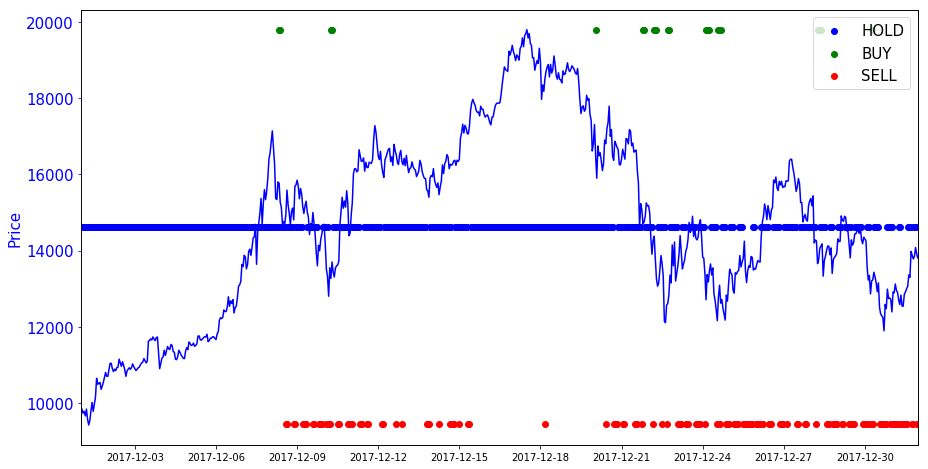

In [135]:
plot_test(test_start, test_end)

# Test on unseen time period (2018-01-01 ~ )

In [137]:
test_start = datetime.datetime(2018,1,1,0)
agent.test(sess, start_time = test_start, verbose=True)

Testing from  2018-01-01 00:00:00  to 2018-04-14 02:00:00 :  ~ 103 days

Current time: 2018-01-01 00:00:00
[[-246.31607 -247.9866  -249.27287]]
Action start: Action.SELL , Total value before action: 5000.0
Before selling: coin:0.000, cash:5000.000, sell price:13471.765
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5000.000
Action end:  Action.HOLD , Total value now: 5000.000.  , Return since entry: 0.000 %

[[-247.55249 -250.3472  -249.5001 ]]
[[-246.27281 -247.69608 -248.5646 ]]
[[-241.3623  -245.43523 -243.55342]]
[[-240.4052  -244.7316  -241.98889]]
[[-236.87378 -241.77144 -238.77417]]
[[-238.09715 -240.65007 -240.26341]]
[[-237.99258 -238.16959 -241.01228]]
[[-239.15843 -237.07433 -242.15742]]
[[-238.34302 -236.20885 -241.90823]]
[[-236.74796 -235.46805 -240.30382]]
[[-236.6636  -235.54716 -240.10733]]
[[-232.49405 -237.06529 -234.41226]]
[[-229.96622 -234.25784 -232.0327 ]]
[[-228.98717 -234.36131 -230.55981]]
[[-226.63896 -231.23416 -228.36157]]

[[-319.09534 -313.1257  -320.86307]]
[[-308.20413 -304.13043 -311.2771 ]]
[[-295.9105  -293.86362 -299.32297]]
[[-285.34988 -295.7955  -286.56198]]
[[-284.6267 -293.8801 -284.9813]]
[[-299.00107 -292.42313 -301.9222 ]]
[[-301.50903 -290.7502  -305.26376]]
[[-297.92133 -282.02817 -304.02658]]
[[-291.62506 -284.8637  -296.93375]]
Current time: 2018-01-09 00:00:00
[[-284.07724 -286.24988 -287.3073 ]]
Action start: Action.SELL , Total value before action: 5000.0
Before selling: coin:0.000, cash:5000.000, sell price:15071.563
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5000.000
Action end:  Action.HOLD , Total value now: 5000.000.  , Return since entry: 0.000 %

[[-287.02695 -287.88992 -291.16037]]
[[-288.41684 -292.86148 -291.25986]]
[[-293.53842 -293.92905 -296.96774]]
[[-300.59656 -295.25916 -305.0761 ]]
[[-302.95813 -297.2618  -306.92438]]
[[-303.8075  -297.56036 -308.32382]]
[[-298.25818 -297.0449  -302.5569 ]]
[[-297.356   -299.57785 -300.64096]]
[

[[-217.35435 -210.47765 -219.63023]]
[[-200.39223 -202.22798 -201.38509]]
[[-188.16948 -194.60814 -189.55954]]
[[-177.55907 -189.49297 -177.52551]]
[[-172.17772 -189.00513 -169.71646]]
[[-178.87878 -185.6574  -177.03899]]
[[-188.9759  -176.39836 -191.45999]]
[[-180.89766 -167.0594  -184.99686]]
[[-167.96367 -163.8137  -170.70543]]
[[-162.73447 -165.01396 -163.86826]]
[[-155.31181 -162.1381  -155.91026]]
[[-159.1038 -159.3137 -160.4815]]
[[-154.43971 -157.71512 -155.21251]]
[[-150.0137  -153.9861  -150.48807]]
[[-140.69884 -146.75305 -141.79535]]
Current time: 2018-01-17 00:00:00
[[-135.93034 -143.4719  -136.20924]]
Action start: Action.SELL , Total value before action: 4883.2274786880025
Before selling: coin:0.061, cash:4222.965, sell price:10776.220
After selling: coin sold:0.006, transaction fees:0.165, coin now:0.055, cash now:4288.826
Action end:  Action.SELL , Total value now: 4883.062.  , Return since entry: -2.339 %

[[-135.33467 -139.21638 -137.22227]]
[[-134.08472 -138.07478 -

[[-120.42792 -131.90211 -122.53334]]
Current time: 2018-01-24 00:00:00
[[-123.207726 -136.24083  -123.74133 ]]
Action start: Action.SELL , Total value before action: 5028.130425901355
Before selling: coin:0.008, cash:4940.238, sell price:10521.885
After selling: coin sold:0.001, transaction fees:0.022, coin now:0.008, cash now:4949.005
Action end:  Action.SELL , Total value now: 5028.108.  , Return since entry: 0.562 %

[[-126.960075 -136.69693  -127.49723 ]]
[[-128.74171 -133.87706 -130.20335]]
[[-124.90916 -130.71077 -126.83368]]
[[-121.91654 -128.6007  -123.34216]]
[[-117.95715  -127.84403  -118.879875]]
[[-118.83257 -125.33669 -120.39137]]
[[-119.06614 -122.86552 -121.94102]]
[[-116.38497 -122.06512 -118.80869]]
[[-117.694695 -123.76198  -120.23385 ]]
[[-118.11288 -124.63879 -120.67631]]
[[-121.6896  -125.42828 -124.50692]]
[[-121.47843 -127.3185  -124.75541]]
[[-122.803406 -128.37958  -126.155205]]
[[-122.081665 -131.79276  -124.79464 ]]
[[-129.06604 -136.9608  -130.92917]]
[[-133

[[ -90.70121 -101.47109  -92.08825]]
[[ -92.5671  -102.20267  -93.81271]]
[[ -94.449196 -100.48383   -96.4784  ]]
[[-89.74746 -99.04756 -91.55926]]
[[-86.36869  -98.495255 -87.47837 ]]
[[-87.09492  -98.928825 -88.22896 ]]
[[-88.789795 -98.85006  -89.80272 ]]
[[-91.50349  -96.774376 -93.69274 ]]
[[-91.100945 -96.28044  -93.56149 ]]
[[-89.42819 -95.25971 -92.08211]]
Current time: 2018-02-01 00:00:00
[[-86.95312 -95.80193 -89.27024]]
Action start: Action.SELL , Total value before action: 5057.554200889139
Before selling: coin:0.000, cash:5057.553, sell price:10174.316
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5057.553
Action end:  Action.SELL , Total value now: 5057.554.  , Return since entry: 1.151 %

[[-88.5534  -97.58501 -90.49047]]
[[-90.11651  -98.55982  -92.319626]]
[[-91.52267 -99.08777 -93.64502]]
[[ -91.18859  -100.214966  -93.002785]]
[[-90.89385  -99.541245 -93.01285 ]]
[[-90.48981  -99.918686 -92.39517 ]]
[[ -89.490105 -101.346985  -90.73

[[193.11559  88.14595 144.9811 ]]
[[241.34885 117.09204 185.03607]]
[[229.62383   59.231842 194.74637 ]]
[[178.13383  25.03564 146.88385]]
[[133.34024   26.068043  91.493004]]
[[68.46652   -6.1474032 40.10972  ]]
[[45.91369   -7.7642055 14.666071 ]]
[[56.77129  -6.578502 21.922676]]
[[ -1.2765776 -19.091993   -4.4791675]]
[[ -8.234762 -23.148325 -10.816718]]
[[ -5.389857 -21.238918  -8.472306]]
[[-12.859237 -28.65511  -13.269473]]
[[ -6.364255 -23.488417  -8.445871]]
[[ -7.6421266 -22.435093   -9.818455 ]]
[[-10.234229  -24.599922  -11.5757885]]
[[-11.693256  -24.176228  -13.0826645]]
[[ -1.0556655 -13.799008   -5.560577 ]]
Current time: 2018-02-09 00:00:00
[[ -3.8862178 -16.923914   -6.7951407]]
Action start: Action.SELL , Total value before action: 5236.20413885778
Before selling: coin:0.005, cash:5200.575, sell price:7875.765
After selling: coin sold:0.000, transaction fees:0.009, coin now:0.004, cash now:5204.129
Action end:  Action.SELL , Total value now: 5236.195.  , Return since

[[-80.27847 -89.97347 -82.66805]]
Current time: 2018-02-16 00:00:00
[[-80.49499  -91.340515 -82.747795]]
Action start: Action.SELL , Total value before action: 5252.168315882083
Before selling: coin:0.000, cash:5252.163, sell price:10155.544
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5252.164
Action end:  Action.SELL , Total value now: 5252.168.  , Return since entry: 5.043 %

[[-80.30404  -93.02465  -82.281075]]
[[-83.66618  -94.86493  -85.481606]]
[[-86.898735 -96.4591   -88.68723 ]]
[[-88.69155 -96.363   -90.6763 ]]
[[-88.317535 -95.07753  -90.919395]]
[[-85.34729  -95.08036  -87.300575]]
[[-84.35129  -96.083916 -85.61161 ]]
[[-83.39947 -95.56367 -84.60955]]
[[-83.90434 -94.43904 -85.22879]]
[[-83.11492 -93.14461 -84.30337]]
[[-81.66331 -91.74245 -82.91569]]
[[-80.04065  -89.389885 -81.71362 ]]
[[-77.529015 -87.84692  -78.96344 ]]
[[-78.21492  -87.600914 -80.09433 ]]
[[-78.51402 -86.31719 -81.13218]]
[[-76.74767  -87.042465 -78.86239 ]]
[[-79.80

[[-82.6358  -92.39782 -85.24175]]
[[-84.687065 -94.3984   -87.09094 ]]
[[-87.07622 -96.69152 -89.36471]]
[[-88.318886 -99.049706 -89.96215 ]]
[[-89.92614 -98.65045 -92.40161]]
[[-90.83224  -99.78745  -92.812485]]
[[ -88.2597   -100.32241   -89.458534]]
[[-87.178   -99.53991 -88.22918]]
[[-87.98582 -98.74505 -89.36024]]
[[-87.66712 -97.31168 -89.37295]]
Current time: 2018-02-24 00:00:00
[[-87.3994   -95.905785 -89.65026 ]]
Action start: Action.SELL , Total value before action: 5255.946006027819
Before selling: coin:0.003, cash:5224.089, sell price:10259.756
After selling: coin sold:0.000, transaction fees:0.008, coin now:0.003, cash now:5227.267
Action end:  Action.SELL , Total value now: 5255.938.  , Return since entry: 5.119 %

[[-86.48899 -96.2152  -88.70098]]
[[-87.38772  -96.970146 -89.50171 ]]
[[-92.17284  -97.57524  -95.158714]]
[[-91.44826 -98.58012 -94.33108]]
[[-92.37918 -99.68887 -95.36599]]
[[ -94.0084   -102.416725  -96.63756 ]]
[[ -95.34008 -104.76232  -97.12645]]
[[ -92.6

[[-134.0825  -140.93156 -136.79668]]
[[-135.30019 -141.85881 -138.1892 ]]
[[-136.2646  -143.63304 -138.97868]]
[[-135.66586 -144.92622 -138.0081 ]]
[[-136.85866 -145.95569 -139.03877]]
[[-138.37122 -147.06108 -140.51035]]
[[-139.21536 -147.34616 -141.36684]]
[[-139.61522 -146.76384 -142.21358]]
[[-140.16422 -147.57558 -142.56175]]
[[-141.16327 -148.11351 -143.73419]]
[[-141.52531 -148.05261 -144.2967 ]]
[[-142.15508 -149.12328 -144.71107]]
[[-142.52966 -149.90724 -145.06444]]
[[-143.08873 -150.1975  -145.79541]]
[[-144.0118  -151.35535 -146.41428]]
[[-144.2077  -152.29523 -146.12547]]
[[-144.29298 -151.12877 -146.70183]]
[[-143.0727  -150.64223 -145.50114]]
Current time: 2018-03-04 00:00:00
[[-141.62413 -150.49278 -143.68442]]
Action start: Action.SELL , Total value before action: 5255.092986316574
Before selling: coin:0.000, cash:5255.093, sell price:11282.752
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5255.093
Action end:  Action.SELL , Total val

[[-44.747955 -57.861538 -45.12611 ]]
Current time: 2018-03-11 00:00:00
[[-43.157314 -54.957672 -43.365173]]
Action start: Action.SELL , Total value before action: 5202.2850468715405
Before selling: coin:0.002, cash:5187.015, sell price:8413.141
After selling: coin sold:0.000, transaction fees:0.004, coin now:0.002, cash now:5188.538
Action end:  Action.SELL , Total value now: 5202.281.  , Return since entry: 4.046 %

[[-40.869984 -51.476406 -41.441586]]
[[-37.456654 -46.662006 -38.819244]]
[[-33.81996 -44.42002 -34.82513]]
[[-30.256021 -41.977486 -31.33512 ]]
[[-29.694311 -40.248184 -31.243046]]
[[-27.875946 -39.3054   -29.356916]]
[[-27.767725 -38.920418 -29.049719]]
[[-29.01861  -38.712376 -31.090021]]
[[-28.88298  -38.19188  -30.921534]]
[[-27.368443 -39.41406  -28.770023]]
[[-27.826536 -39.55186  -29.885172]]
[[-21.934612 -34.640957 -25.918451]]
[[-25.007887 -40.381214 -27.300993]]
[[-32.34065  -45.71623  -34.087772]]
[[-38.63434  -47.293762 -41.171124]]
[[-41.480846 -49.601997 -43

[[503.72687 163.19653 494.0032 ]]
[[539.87823 204.1129  517.9507 ]]
[[577.1474  187.55579 571.4363 ]]
[[543.91254 184.75848 533.7652 ]]
[[464.10034 253.44772 405.174  ]]
[[472.13834 289.93253 394.90775]]
[[563.8865  250.9907  515.34106]]
Current time: 2018-03-19 00:00:00
[[469.89938 232.05135 408.25272]]
Action start: Action.SELL , Total value before action: 5184.744982462835
Before selling: coin:0.000, cash:5184.726, sell price:8233.364
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5184.728
Action end:  Action.SELL , Total value now: 5184.745.  , Return since entry: 3.695 %

[[313.35376 181.47289 247.36864]]
[[244.36852 120.09076 191.97076]]
[[243.7489  111.13164 189.80276]]
[[234.42996   92.680046 181.70705 ]]
[[192.0642    12.114667 169.17146 ]]
[[84.085724  -5.4655013 59.518528 ]]
[[ 45.226524 -10.352926  25.39817 ]]
[[ 36.905834 -10.941949  16.101816]]
[[ 13.150113  -12.080594   -1.6770483]]
[[ 12.179262 -13.035753  -1.373967]]
[[48.009182 -8.845

[[-10.683394 -25.259016 -12.59689 ]]
[[-12.043682 -25.756346 -13.439692]]
[[-10.139842 -24.55625  -11.578025]]
[[ -5.90667   -21.251207   -7.6545496]]
[[ -2.893213  -18.69803    -4.9017653]]
[[ -0.35226   -17.25295    -2.1863792]]
[[ 12.14509    -13.578966    -0.12726222]]
[[ 22.98202  -10.504611   6.838112]]
[[32.348537 -8.958047 17.239016]]
[[92.816895   3.2402022 65.56171  ]]
[[110.05407   10.654808  83.66991 ]]
[[163.71469   18.081528 144.58156 ]]
[[176.81847   36.326378 149.61894 ]]
[[165.40282   54.159973 128.64655 ]]
Current time: 2018-03-27 00:00:00
[[171.44833   48.107143 138.37921 ]]
Action start: Action.SELL , Total value before action: 5184.744975472483
Before selling: coin:0.000, cash:5184.745, sell price:8140.017
After selling: coin sold:0.000, transaction fees:0.000, coin now:0.000, cash now:5184.745
Action end:  Action.SELL , Total value now: 5184.745.  , Return since entry: 3.695 %

[[154.43953   47.035587 117.58942 ]]
[[122.109566  31.993877  89.058304]]
[[121.93449  

[[670.72546 506.56204 675.26337]]
[[688.7574  490.06183 690.39294]]
[[662.1471  451.38464 664.62665]]
[[633.8946 410.8714 640.5456]]
[[568.04144 356.30493 575.51465]]
[[499.45355 328.30887 498.20926]]
[[506.81506 310.19632 504.96887]]
[[553.43286 295.02396 555.1287 ]]
[[497.99652 252.64148 502.39432]]
[[485.99365 225.3073  496.52283]]
[[447.71335 193.9069  461.5251 ]]
[[407.07123 185.05183 417.85748]]
[[428.71082 179.50795 444.55255]]
[[393.71973 180.45312 403.43564]]
[[378.96774 171.40689 387.7194 ]]
[[384.80237 167.43864 393.5587 ]]
[[368.75958 163.83667 372.62946]]
[[354.14944 132.85698 365.99786]]
[[308.0661  116.10092 317.52322]]
[[308.75244 120.98155 313.66318]]
[[321.91284  105.394905 335.58734 ]]
Current time: 2018-04-04 00:00:00
[[322.50262 100.72328 336.19473]]
Action start: Action.BUY , Total value before action: 5431.26849775814
Before buying: coin:0.707, cash:237.711, buy price:7450.325
After buying: coin bought:0.003, transaction fees:0.059, coin now:0.710, cash now:213.8

[[908.8742  731.8645  921.64545]]
[[904.6463  716.25323 921.38104]]
[[896.49994 706.50275 912.6709 ]]
[[894.52966 701.0756  909.58514]]
[[873.6059 679.6454 893.6258]]
Current time: 2018-04-11 00:00:00
[[882.85767 677.16284 902.9413 ]]
Action start: Action.BUY , Total value before action: 5038.185858124608
Before buying: coin:0.740, cash:0.000, buy price:6905.904
After buying: coin bought:0.000, transaction fees:0.000, coin now:0.740, cash now:0.000
Action end:  Action.BUY , Total value now: 5038.186.  , Return since entry: 0.764 %

[[867.9553  674.05414 888.0676 ]]
[[871.7899 672.6703 891.838 ]]
[[860.33   671.0896 881.4855]]
[[865.8789  674.72235 885.9994 ]]
[[872.8259  675.46625 894.1147 ]]
[[839.51605 678.9437  853.08014]]
[[870.58923 675.90155 889.67346]]
[[871.8022 675.8222 892.2113]]
[[864.42896 674.13776 881.1174 ]]
[[859.18616 670.8602  879.3818 ]]
[[860.3258  669.50214 878.9766 ]]
[[861.34503 668.67395 880.59393]]
[[856.01184 669.243   870.8571 ]]
[[848.5304 663.3172 861.1108]

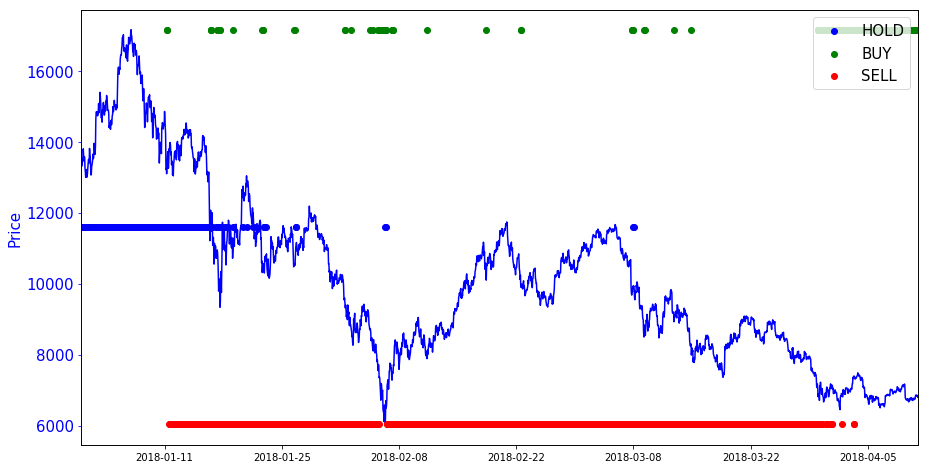

In [138]:
plot_test(test_start, datetime.datetime(2018,4,11,0))

# Save Model (Optional)

In [15]:
# to be implemented.... sorry....

# Always buy agent

In [204]:
from simple_agents import *

In [205]:
always_buy_agent = AlwaysBuyAgent(Action)

In [206]:
env = Environment()
now = datetime.datetime(2017,12,1,0)
test_end = datetime.datetime(2018,1,1,0)
env.set_current_time(now)
portfolio = Portfolio(cash_supply=1e8)
while True:
    action = always_buy_agent.get_action()
    if (env.current_index - env.start_index) / env.time_delta % 24 == 0:
        verbose = True
        print('Current time:', env.current_index)
    else:
        verbose = False
    current_price = env.getCurrentPrice()
    action = portfolio.apply_action(current_price, action, verbose=verbose)
    is_done, state = env.step()
    if env.current_index == test_end:
        break
print("Initial cash supply:", portfolio.starting_cash)
print("Final holdings:", portfolio.getCurrentHoldings(env.getCurrentPrice()))

Current time: 2017-12-01 13:00:00
Action start: Action.BUY , Total value before action: 101768167.32603675
Before buying: coin:7583.457, cash:25327021.511, buy price:10218.013
After buying: coin bought:247.866, transaction fees:6331.755, coin now:7831.323, cash now:22787987.604
Action end:  Action.BUY , Total value now: 101727623.464.  , Return since entry: 1.728 %

Current time: 2017-12-02 13:00:00
Action start: Action.BUY , Total value before action: 109454130.3945612
Before buying: coin:9763.814, cash:2006821.046, buy price:11155.333
After buying: coin bought:17.990, transaction fees:501.705, coin now:9781.804, cash now:1805637.237
Action end:  Action.BUY , Total value now: 109450917.846.  , Return since entry: 9.451 %

Current time: 2017-12-03 13:00:00
Action start: Action.BUY , Total value before action: 114972193.9853586
Before buying: coin:9931.208, cash:159013.199, buy price:11719.152
After buying: coin bought:1.357, transaction fees:39.753, coin now:9932.564, cash now:143072.1

Current time: 2017-12-30 13:00:00
Action start: Action.BUY , Total value before action: 123570645.59934495
Before buying: coin:9944.905, cash:0.000, buy price:12595.667
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 123570645.599.  , Return since entry: 23.571 %

Current time: 2017-12-31 13:00:00
Action start: Action.BUY , Total value before action: 128366983.95875396
Before buying: coin:9944.905, cash:0.000, buy price:13084.562
After buying: coin bought:0.000, transaction fees:0.000, coin now:9944.905, cash now:0.000
Action end:  Action.BUY , Total value now: 128366983.959.  , Return since entry: 28.367 %

Initial cash supply: 100000000.0
Final holdings: 9944.90 coins, 0.00 cash, 136306457.98 current value, 36.31 percent returns
